# Add_feature 1
* 기존변수 + u-g,g-r,r-i,i-z만 추가변수로 사용
* category_features 사용위해 lgb.train사용
* 제출결과 : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

C:\Users\starl\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

## DATA Setting

In [5]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [6]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [8]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [9]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

In [11]:
train_X = train_df.drop(columns=['type', 'type_num'], axis=1)
train_y = train_df['type_num']
test_X = test_df

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [13]:
train_ds = lgb.Dataset(X_train, label = y_train, categorical_feature=['fiberID'])
test_ds = lgb.Dataset(X_test, label = y_test, categorical_feature=['fiberID']) 

In [14]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.005,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [15]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 20000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.28404	Test's multi_logloss: 1.30586
[200]	Train's multi_logloss: 0.900804	Test's multi_logloss: 0.936238
[300]	Train's multi_logloss: 0.687019	Test's multi_logloss: 0.734482
[400]	Train's multi_logloss: 0.554989	Test's multi_logloss: 0.613457
[500]	Train's multi_logloss: 0.468813	Test's multi_logloss: 0.538725
[600]	Train's multi_logloss: 0.410511	Test's multi_logloss: 0.491203
[700]	Train's multi_logloss: 0.369462	Test's multi_logloss: 0.460285
[800]	Train's multi_logloss: 0.338973	Test's multi_logloss: 0.439923
[900]	Train's multi_logloss: 0.31525	Test's multi_logloss: 0.42659
[1000]	Train's multi_logloss: 0.296122	Test's multi_logloss: 0.417483
[1100]	Train's multi_logloss: 0.280345	Test's multi_logloss: 0.411408
[1200]	Train's multi_logloss: 0.266888	Test's multi_logloss: 0.407214
[1300]	Train's multi_logloss: 0.255063	Test's multi_logloss: 0.404307
[1400]	Train's multi_logloss: 0.244527	Te

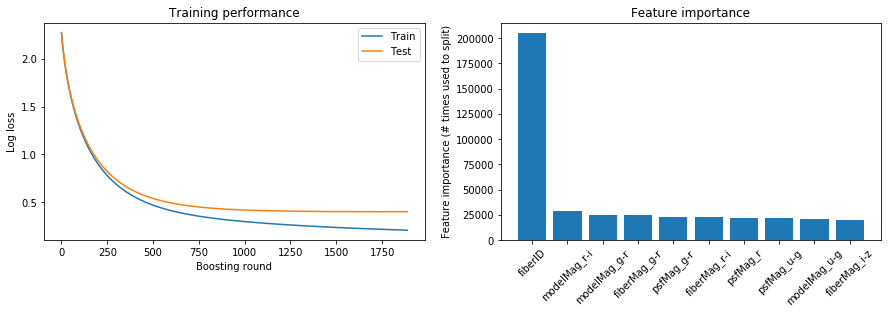

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [17]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [18]:
train_y_pred.shape

(59998, 19)

In [19]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3994730997626283

In [20]:
lgmb_model.feature_importance()

array([205116,  14856,  19836,  22390,  17722,  16056,  12712,  14019,
        15813,  16509,  12438,  11735,   9878,   9753,  15223,  11360,
        12947,  13300,   9346,  12198,  16580,  21821,  23383,  16801,
        17046,  19488,  24601,  22923,  20288,  19722,  18135,  15929,
        11976,  20894,  25202,  28464,  19320])

### feature_importance

In [21]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
fiberID,205116
modelMag_r-i,28464
modelMag_g-r,25202
fiberMag_g-r,24601
psfMag_g-r,23383
fiberMag_r-i,22923
psfMag_r,22390
psfMag_u-g,21821
modelMag_u-g,20894
fiberMag_i-z,20288


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0,2,7,11
망한예측 : 12,17

In [22]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [23]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,235,1,0,0,17,55,4,168,59,0,0,20,0,1,18,10,0,0,60
1,1,1877,0,0,0,1,1,3,17,0,3,4,0,0,0,0,5,0,40
2,0,0,72,72,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0
3,0,0,39,635,0,0,0,0,0,2,93,0,0,0,0,0,0,0,0
4,2,0,0,0,4252,23,0,0,11,0,0,11,0,0,0,87,0,0,0
5,35,0,1,0,155,3633,2,67,54,0,0,6,0,0,0,85,0,0,12
6,2,22,0,0,12,2,10905,4,89,1,0,48,0,86,21,12,0,0,0
7,135,0,0,0,0,198,0,691,21,0,0,1,0,0,0,1,0,0,349
8,10,12,2,6,32,228,121,32,13133,0,13,214,0,78,82,9,15,0,917
9,0,0,0,0,0,0,0,0,10,28,0,0,0,0,0,0,0,0,0


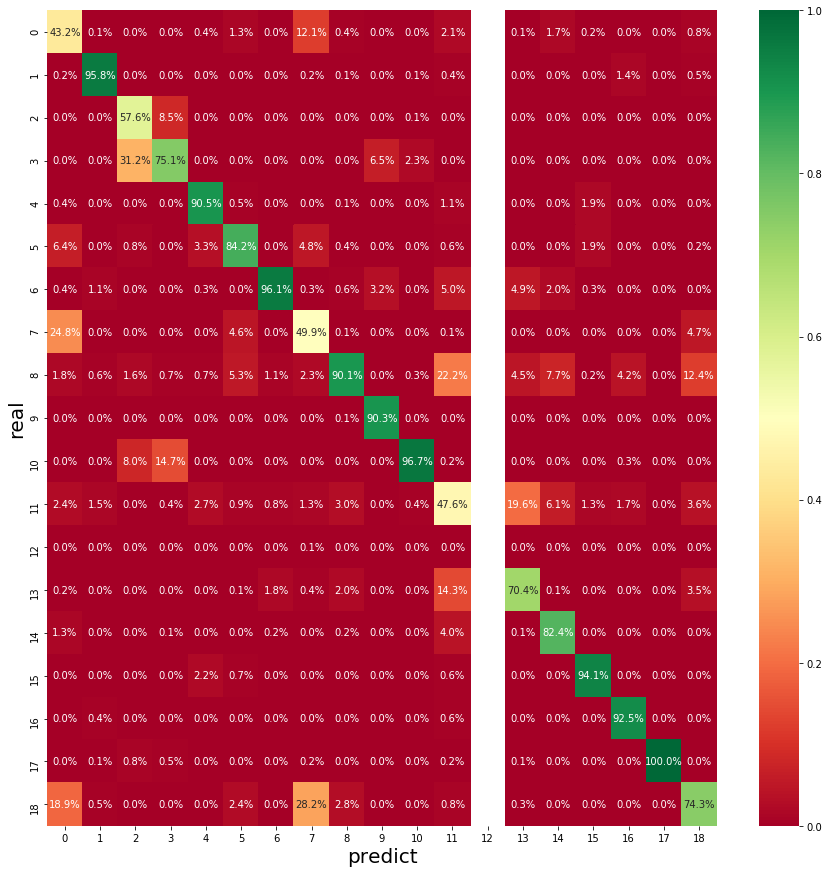

In [24]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [25]:
train_ds = lgb.Dataset(train_X, label = train_y, categorical_feature=['fiberID'])

In [26]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [27]:
y_pred = lgmb_model.predict(test_X)

In [28]:
y_pred

array([[2.30701555e-05, 5.90508310e-05, 5.44271394e-05, ...,
        1.28932762e-05, 2.03284818e-06, 1.92137967e-04],
       [1.95260417e-04, 4.46474240e-04, 3.06560648e-05, ...,
        6.97552776e-05, 7.31987439e-06, 1.85333184e-03],
       [8.02607174e-05, 2.07283131e-05, 1.23841913e-06, ...,
        2.79584992e-06, 3.23958500e-07, 6.35004189e-05],
       ...,
       [1.90413012e-04, 3.68564915e-04, 1.87559332e-05, ...,
        4.23433173e-05, 4.48626626e-06, 7.39447762e-02],
       [4.90989164e-06, 1.10242655e-05, 7.24001536e-07, ...,
        1.63450288e-06, 1.70846424e-07, 3.35158401e-04],
       [4.96936029e-04, 6.97292604e-06, 4.40251207e-07, ...,
        9.93909306e-07, 1.05837611e-07, 3.87978071e-05]])

In [30]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)